### Import Packages and Datasets

To begin working with the FDA recall data, first import the necessary general packages, the data processing modules, and set your directory paths.

In [17]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

In [18]:
import os
import pandas as pd
import csv
import re
import sys

In [19]:
sys.path.append('/Users/tajimakeijiro/Desktop/uwescience')

In [20]:
import dataproc.UPC_ASIN_Process as uap
import dataproc.FDA_Preprocess as pp
import dataproc.DataFrame_io as dfio

In [21]:
wd = os.getcwd()
wd

'/Users/tajimakeijiro/Desktop/uwescience/notebooks'

In [22]:
wd = os.getcwd()
outer = os.path.join(wd, "..")
data_dir = os.path.join(wd,"..","data")
git_data_dir = os.path.join(wd,"..","github_data")

Next, import the FDA Recall Press Release Data and FDA Recall Enforcement Report Data, and read them into a Pandas DataFrame.

In [23]:
press = pd.read_csv(os.path.join(data_dir,"processed", "FDA_recalls_2.csv"),skip_blank_lines = True,encoding='ISO-8859-1', index_col = 0).fillna("")
enforce = pd.read_csv(os.path.join(data_dir,"processed","FDA_food_enforcements_2012-06_to_2016-07.csv"), encoding = 'ISO-8859-1')

The rows in the DataFrame correspond to an individual FDA recall. Each recall is associated with a single company and reason for recall, but may be associated with more than one product. The columns containing the information concerning the recalls vary between the two datasets, with the `enforce` data containing more detailed and FDA-specific information then the `press` data. 

In [24]:
press.iloc[0:1]

,BRAND_NAME,PRODUCT_DESCRIPTION,REASON,COMPANY,COMPANY_RELEASE_LINK,PHOTOS_LINK
DATE,,,,,,
"Wed, 31 Dec 2014 18:38:00 -0500",Whole Foods,Cheeses,Listeria monocytogenes,Whole Foods Market,http://wayback.archive-it.org/7993/20170406200...,http://wayback.archive-it.org/7993/20170406200...


In [25]:
enforce.iloc[0:1]

,Product.Type,Recently.Updated.Record,Last.Modified.Date,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,...,Recall.Number,Classification,Product.Description,Product.Quantity,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info
0,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,F-0231-2014,Class I,"Macaroni Reg CAD, Formula MA.50, Macaroni Sal...",NaN,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by dates: 10/21/13-12/11/13.


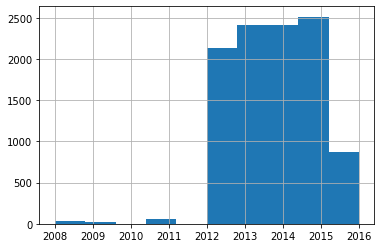

In [26]:
enforce_new = enforce['Recall.Initiation.Date'].str.split("/", n=2, expand=True)[2].sort_values()[1:]
enforce_new.hist()

## Extract UPCs from text fields

The first step in processing the FDA data is to extract the UPCs from the text fields they are contained in by making use of the `makeUPCCol` function in the `FDA_Preprocess` module (documenation can be found [HERE]). The function operates in one of two ways depending on what is passed in for `string_list`. These two ways are exemplified by the two different FDA datasets `press` and `enforce`, with the parameter `link` as `True` and `False` respectively.

### Press Release Dataset (`link = True`)

In the Press Release Dataset, the text containing the product information, including UPCs, resides in the page linked to by the URL in the `COMPANY_RELEASE_LINK` column-- the text itself is not contained table.

In order to use the `makeUPCCOl` function with this dataset, you must pass `True` for the `link` parameter. This indicates that the `string_list` parameter being passed is a list of URLs rather than a list of strings.  The `makeUPCCol` function calls the `makeUPCList` function for each row in the dataset, and utilizes the Beautiful Soup with an HTML parser to pull out the text contained within the page. The value passed for `link` also indicates the default regex pattern that should be used for finding UPCs within the text. If `link=True` is passed, the default for the pattern parameter is `UPC_PATTERN_PAGE`. This regex pattern is ideal when the text being searched is an XML because it slightly stricter than the `UPC_PATTERN_TEXT` pattern, and is less likely to pull out unrelated number clusters or partial UPCs.

Create and append a new column called `upc` to the `press` DataFrame that contains the list of UPCs associated with each recall:

In [27]:
# press["upc"] = pp.makeUPCCol(press["COMPANY_RELEASE_LINK"], link = True, verbose = True)

0 rows processed
500 rows processed
1000 rows processed
1287 rows processed : COMPLETE


In [28]:
press = pd.read_csv("press.csv")
press["upc"]c

DATE
Wed, 31 Dec 2014 18:38:00 -0500                                                   []
Wed, 31 Dec 2014 15:28:00 -0500                                                   []
Wed, 31 Dec 2014 14:48:00 -0500                             [1111078622, 1111085763]
Wed, 31 Dec 2014 00:00:00 -0500                                                   []
Tue, 30 Dec 2014 18:51:00 -0500                                                   []
                                                         ...                        
Tue, 03 Jan 2012 21:21:00 -0500    [815098002054, 815098000258, 815098000272, 815...
Tue, 03 Jan 2012 00:00:00 -0500                         [072820140457, 041220248469]
Tue, 03 Jan 2012 00:00:00 -0500                                                   []
Tue, 03 Jan 2012 00:00:00 -0500                                                   []
Tue, 03 Jan 2012 00:00:00 -0500                                                   []
Name: upc, Length: 1287, dtype: object

### Enforcement Dataset (`link = False`)

In the Enforcement data, the product information is contained in strings within the `Code.Info` or `Product.Description` columns. The default parameter `link=False` is the correct value for this dataset, indicating that `string_list` parameter is a list of strings containing the UPCs. When `link=False`, the default parameter for `pattern`, `UPC_PATTERN_TEXT`, is used. This is the optimal pattern when searching strings directly-- it is slightly more liberal with the patterns that it looks for and is able to capture more number clusters without fear of false matches or incomplete UPCs. 

Create and append a new column called `upc_pd` to the `enforce` DataFrame that contains the list of UPCs for each recall found in the `Product.Description` column:

In [34]:
enforce['upcs_pd'] = pp.makeUPCCol(enforce["Product.Description"], verbose = False)

Create and append a new column called `upc_ci` to the `enforce` DataFrame that contains the list of UPCs for each recall found in the `Code.Info` column:

In [35]:
enforce['upcs_ci'] = pp.makeUPCCol(enforce["Code.Info"], verbose = False)

Processing the `enforce` data is much faster, and there are many more rows, so we pass `verbose=False` to keep the function from printing out status messages.

We next combine the UPCs found the `Product.Description` and `Code.Info` columns and obtain a list containing the unique UPCs for each recall. 

Append a column called `upc` to the `enforce` DataFrame that contains the list UPCs associated with each recall:

In [36]:
union_col = [list(set(enforce.upcs_pd[rownum]).union(set(enforce.upcs_ci[rownum]))) for rownum in range(enforce.shape[0])]
enforce['upc'] = pd.Series(union_col)

Additionally, create a list of all of the 12 digit UPCs from an recall event to be used for pattern matching in the UPC processing stage using the `makeEventUPCCol` function:

In [37]:
enforce["event_upc12"] = pp.makeEventUPCCol(enforce["upc"], enforce["Event.ID"])

In [38]:
enforce.iloc[0:1]

,Product.Type,Recently.Updated.Record,Last.Modified.Date,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,...,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,upcs_pd,upcs_ci,upc,event_upc12
0,Food,No,NaN,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,NaN,Beaverton,OR,...,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by dates: 10/21/13-12/11/13.,"[071117002164, 071117001631, 071117646078, 074...",[],"[074865208369, 071117002164, 071117613223, 071...","[071117001624, 074865800389, 071117141337, 628..."


## DataFrame Import/Export

Python lists within Pandas DataFrames are not read in and out as strings, so we created a set of functions in the DataFrame_io submodule to convert between these types more easily. 

### Write Data Out

Convert the lists of UPCs in both DataFrames to semi-colon delimited strings:

In [39]:
press["upc"] = pd.Series(dfio.listToStringCol(press["upc"]))

In [40]:
enforce["upc"] = pd.Series(dfio.listToStringCol(enforce["upc"]))
enforce["event_upc12"] = pd.Series(dfio.listToStringCol(enforce["event_upc12"]))

Write both DataFrames to CSVs:

In [41]:
#ignore if you wish to keep the colums showing the UPCs extracted from each column seperately
enforce.drop(["upcs_pd", "upcs_ci"], axis = 1, inplace = True)

In [42]:
press.to_csv(os.path.join(git_data_dir, "press_upc.csv"))

In [43]:
enforce.to_csv(os.path.join(git_data_dir, "enforce_upc.csv"))

### Read Data In

Read CSVs into DataFrames:

In [44]:
press = pd.read_csv(os.path.join(git_data_dir, "press_upc.csv"), index_col = 0).fillna("")


In [45]:
enforce = pd.read_csv(os.path.join(git_data_dir, "enforce_upc.csv"), index_col = 0).fillna("")

In [46]:
press.iloc[0:2]

,BRAND_NAME,PRODUCT_DESCRIPTION,REASON,COMPANY,COMPANY_RELEASE_LINK,PHOTOS_LINK,upc
DATE,,,,,,,
"Wed, 31 Dec 2014 18:38:00 -0500",Whole Foods,Cheeses,Listeria monocytogenes,Whole Foods Market,http://wayback.archive-it.org/7993/20170406200...,http://wayback.archive-it.org/7993/20170406200...,
"Wed, 31 Dec 2014 15:28:00 -0500",Jump Your Bones,Pet treats,Salmonella,"Jump Your Bones, Inc.",http://wayback.archive-it.org/7993/20170406200...,http://wayback.archive-it.org/7993/20170406200...,


In [47]:
enforce.iloc[0:2]

,Product.Type,Recently.Updated.Record,Last.Modified.Date,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,...,Product.Description,Product.Quantity,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,upc,event_upc12
0,Food,No,,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,,Beaverton,OR,...,"Macaroni Reg CAD, Formula MA.50, Macaroni Sal...",,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by dates: 10/21/13-12/11/13.,074865208369;071117002164;071117613223;0711170...,071117001624;074865800389;071117141337;6289190...
1,Food,No,,66563,Terminated,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,,Beaverton,OR,...,"Reser's Fine Foods, Cheesy Macaroni Salad, For...",,The recalled products are potentially contamin...,10/22/2013,12/24/2013,01/24/2017,01/01/2014,Use by date 10/20/13 and 12/01/13.,071117612271;071117182415;,071117001624;074865800389;071117141337;6289190...


In [48]:
press["upc"]=pd.Series(dfio.stringToListCol(press["upc"]), index = press.index)

In [49]:
enforce["upc"] = pd.Series(dfio.stringToListCol(enforce["upc"]))
enforce["event_upc12"] = pd.Series(dfio.stringToListCol(enforce["event_upc12"]))

## Process UPCs and lookup ASINs

Next process the UPCs using the `makeUPCProcessedList` function in the `UPC_ASIN_Process` module determine the correct 12-digit UPC, or list of possible 12-digit UPCs for each UPC extracted. This function allows for an optional parameter of `event_upc12_list` to be passed. This is a list of potentially similar UPCs that, through various pattern matching strategies, can be used to determine the correct 12-digit UPC. Then lookup the ASIN for each 12-digit UPC using the `getASIN` function. When processing the UPCs in an entire DataFrame, it is more efficient to use the `makeUPCProcessedASINTuples` function, which processed the UPC and does the ASIN lookup at the same time. The function returns a list of tuples in the format `(row_number, upc_processed_nestedlist, asin_nestedlist)`.  
Given the large number of UPCs and the API rate rate limit of 1 query per second, this process takes a significant period of time. It is therefore encouraged to pass the `pickle=True` (as well as `verbose=True` in order to keep track of the functions progress) parameter. The function will then use the Python pickling process (https://docs.python.org/3/library/pickle.html) to update and save the list of tuples to the file `data_pickle` every 200 rows.  

In [50]:
import pickle

First process the press data, passing the name of the DataFrame, the name of the column containing the UPCs, and both pickle and verbose as True. The parameter `event_upc12_colname` is left at the default value of `None`, indicating that the list of potentially similar UPCs to be used for pattern matching should be constructed from all of the 12-digit UPCs from the same FDA recall. The `rowrange` parameter is also left at the default, indicating that the entire DataFrame should be processed. 

In [51]:
#Console output not shown
press_tuple_list = uap.makeUPCProcessedASINTuples(press, "upc", pickle_filename = 'press_pickle', verbose = True)

200 rows processed & saved
400 rows processed & saved
600 rows processed & saved
800 rows processed & saved
1000 rows processed & saved
1200 rows processed & saved
1287 rows processed & saved


When the process is complete (the last line printed should read: `3154 rows processed & saved`), the processed tuples should be stored in `press_tuples` as well as to the location specified in `pickle_filename`.

Open the pickled file and check the first tuple and the length of the list to ensure that the process went smoothly

In [52]:
with open('press_pickle', 'rb') as file:
    press_tuples = pickle.load(file)

In [53]:
press_tuples[-1]

(1286, [], [])

In [54]:
len(press_tuples)

1287

Then repeat the process with the enforce data. This time, pass the `event_upc12_colname` as `event_upc12`, which was prepared in the FDA Preprocessing section above. 

In [55]:
#Console output not shown
enforce_tuple_list = uap.makeUPCProcessedASINTuples(enforce, "upc", event_upc12_colname = "event_upc12", pickle_filename = 'enforce_pickle', verbose = True)

200 rows processed & saved
400 rows processed & saved
600 rows processed & saved
800 rows processed & saved


KeyboardInterrupt: 

If your notebook stops running, or a error is thrown by the API, the pickling and saving process ensures that the work is not lost and one can more or less pick up where they left off. The last save point can be determined either from the last the status printed to the console (e.g. `3200 rows processed & saved`) or by reading in the pickle file and checking the length or indices. Indices are included in the tuples in order to make processing the data in pieces and later recombining simpler and easier to check. Again, be sure and rename the pickle file before proceeding with the rest of the data processing. 

In [63]:
with open('enforce_pickle', 'rb') as file:
    enforce_tuples_1 = pickle.load(file)

In [64]:
enforce_tuples_1[-1]

(10467, [], [])

Pass the `rowrange` parameter as a (`first_row','last_row`) tuple in order to continue from the last save point:

In [65]:
#console output not shown
enforce_tuple_list = uap.makeUPCProcessedASINTuples(enforce, "upc", event_upc12_colname = "event_upc12", rowrange = (2200, enforce.shape[0]), pickle_filename = 'enforce_pickle_2200', verbose = True)

2400 rows processed & saved
2600 rows processed & saved
2800 rows processed & saved
3000 rows processed & saved
3200 rows processed & saved
3400 rows processed & saved
3600 rows processed & saved
3800 rows processed & saved
4000 rows processed & saved
4200 rows processed & saved
4400 rows processed & saved
4600 rows processed & saved
4800 rows processed & saved
5000 rows processed & saved
5200 rows processed & saved
5400 rows processed & saved
5600 rows processed & saved
5800 rows processed & saved
6000 rows processed & saved
6200 rows processed & saved
6400 rows processed & saved
6600 rows processed & saved
6800 rows processed & saved
7000 rows processed & saved
7200 rows processed & saved
7400 rows processed & saved
7600 rows processed & saved
7800 rows processed & saved
8000 rows processed & saved
8200 rows processed & saved
8400 rows processed & saved
8600 rows processed & saved
8800 rows processed & saved
9000 rows processed & saved
9200 rows processed & saved
9400 rows processed 

Open the pickle file(s), combine the lists:

In [66]:
with open('enforce_pickle_2200', 'rb') as file:
    enforce_tuples_2 = pickle.load(file)

In [67]:
enforce_tuples = enforce_tuples_1+enforce_tuples_2

In [68]:
len(enforce_tuples)

18736

Next read the tuple lists into Pandas DataFrames:

In [69]:
press_codes_df = pd.DataFrame.from_records(press_tuples, columns = ["row", "upc_processed", "asin"])
enforce_codes_df = pd.DataFrame.from_records(enforce_tuples, columns = ["row", "upc_processed", "asin"])

Make sure that the index and `row` columns match-- this is a good check to make sure that recombining the lists worked correctly. The redundant `row` columns can then be dropped.

In [70]:
press_codes_df.iloc[-2:-1]

,row,upc_processed,asin
1285,1285,[],[]


In [71]:
enforce_codes_df.iloc[-2:-1]

,row,upc_processed,asin
18734,10466,[],[]


In [72]:
press_codes_df.drop(["row"], axis = 1, inplace = True)
enforce_codes_df.drop(["row"], axis = 1, inplace = True)

Unfortunately, for a variety of reasons, querying the API for the ASIN does not always work correctly, and the response can be a long error code rather than than the 10 character ASIN or `UPCNOTFOUND`. Instead of querying the the API again if it returns a "error string", it is far more efficient to look for and fix these after the initial processing is complete. 
Use the `fixASINErrors` function on both DataFrames. This should fix all of the error strings, but this can be double checked by running the function again and checking that `0 Error Strings found and fixed` is printed.

In [73]:
press_codes_df["asin"] = uap.fixASINErrors(press_codes_df["asin"], press_codes_df["upc_processed"])

0 Error Strings found and fixed


In [74]:
enforce_codes_df["asin"] = uap.fixASINErrors(enforce_codes_df["asin"], enforce_codes_df["upc_processed"])

0 Error Strings found and fixed


The number of error strings found and fixed will differ on each run of the `makeUPCProcessedASINTuples` process and will likely not be the same as the console output shown above. To ensure that all of these were caught, especially of the number of error strings found was very high, run this function again, and check `0 Error Strings found and fixed` is printed for each.

In [75]:
press_codes_df["asin"] = uap.fixASINErrors(press_codes_df["asin"], press_codes_df["upc_processed"])
enforce_codes_df["asin"] = uap.fixASINErrors(enforce_codes_df["asin"], enforce_codes_df["upc_processed"])

0 Error Strings found and fixed
0 Error Strings found and fixed


In [78]:
press_full = pd.concat([press, press_codes_df], axis = 1)
enforce_full = pd.concat([enforce, enforce_codes_df], axis = 1)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [77]:
press_full.iloc[0:1]

NameError: name 'press_full' is not defined

In [33]:
enforce_full.iloc[0:1]

,Product.Type,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,Postal.Code,Country,...,Reason.for.Recall,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,upc,event_upc12,upc_processed,asin
0,Food,66563,Completed,"Reser's Fine Foods, Inc.",15570 SW Jenkins Road,,Beaverton,OR,97006,United States,...,The recalled products are potentially contamin...,10/22/2013,12/24/2013,,01/01/2014,Use by dates: 10/21/13-12/11/13.,"[071117002164, 071117001631, 071117613223, 074...","[079453214722, 071117616507, 758108301566, 071...","[[071117002164], [071117001631], [071117613223...","[[B00JVD5VMY], [B01EX9EHUM], [B004P4S7QG], [B0..."


## Review Data

Next, join the FDA recall data with the Amazon Review data found on Julian McAuley's website http://jmcauley.ucsd.edu/data/amazon/. Download the "Grocery and Gourmet Food" "review" and "metadata" datasets under the  "Per-category files" heading.

First, run the functions provided by McAuley to read the data into a Pandas Dataframe. Then read in the review data as well as the metadata (this may take some time). Then merge the two dataframes.

In [36]:
#Code from Julian McAuley
import json
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [37]:
df = getDF(os.path.join(data_dir, "reviews_Grocery_and_Gourmet_Food.json.gz"))

In [36]:
df.iloc[0:1]

,overall,reviewerID,summary,asin,reviewerName,reviewTime,helpful,unixReviewTime,reviewText
0,5.0,A1ZQZ8RJS1XVTX,Best vanilla I've ever had,0657745316,gsxrgirl,"10 11, 2013","[0, 0]",1381449600,"No sugar, no GMO garbage, no fillers that come..."


In [37]:
metadata = getDF(os.path.join(data_dir, "meta_Grocery_and_Gourmet_Food.json.gz"))

In [38]:
#ignore if you wish to keep these columns
metadata_col_subset = metadata.drop(["imUrl", "related"],1)

In [39]:
full_df = pd.merge(df, metadata_col_subset, how = "left", on = ["asin"])

In [40]:
full_df.iloc[0:1]

,overall,reviewerID,summary,asin,reviewerName,reviewTime,helpful,unixReviewTime,reviewText,description,salesRank,title,categories,price,brand
0,5.0,A1ZQZ8RJS1XVTX,Best vanilla I've ever had,0657745316,gsxrgirl,"10 11, 2013","[0, 0]",1381449600,"No sugar, no GMO garbage, no fillers that come...",This is real vanilla extract made with only 3 ...,{'Grocery & Gourmet Food': 374004},100 Percent All Natural Vanilla Extract,[[Grocery & Gourmet Food]],NaN,NaN


Create a list of unique asins from the review data, and pass this as a parameter to the `makeRecallReviewTuples` function to create a list of matched asins, along with their corresponding processed upcs, recall dates, and recall numbers. This function also appends an `asin_match` column to the FDA dataframes indicating the asin (if one exists) that matched the amazon review data. 

In [41]:
review_asins_unique = list(set(full_df["asin"]))

In [43]:
len(review_asins_unique)

166049

In [61]:
press_asin_tuples = uap.makeRecallReviewTuples(press_full, "upc_processed", "asin", "DATE", review_asins_unique)

In [62]:
enforce_asin_tuples = uap.makeRecallReviewTuples(enforce_full, "upc_processed", "asin", "Recall.Initiation.Date", review_asins_unique, "Recall.Number")

In [63]:
press_asin_tuples_unique = list(set(press_asin_tuples))
enforce_asin_tuples_unique = list(set(enforce_asin_tuples))

In [64]:
len(press_asin_tuples_unique)

193

In [65]:
len(enforce_asin_tuples_unique)

166

There are 193 and 166 unique matching asins found in the press and enforcement data respectively. Note that there is still overlap between the two sets of matching asins.

In [76]:
press_asin_tuples_unique[0:3]

[('B00B044BNW', '038000318344', '1101', 'Mon, 08 Oct 2012 00:00:00 -0400'),
 ('B0035HCRRY', '085239803509', '2580', 'Tue, 07 Apr 2009 00:00:00 -0400'),
 ('B00CPJB9OA', '033079150734', '1110', 'Thu, 04 Oct 2012 00:00:00 -0400')]

In [78]:
press_full[press_full["asin_match"] == 'B00CPJB9OA']

,DATE,BRAND_NAME,PRODUCT_DESCRIPTION,REASON,COMPANY,COMPANY_RELEASE_LINK,PHOTOS_LINK,upc,upc_processed,asin,asin_match
1076,"Fri, 12 Oct 2012 00:00:00 -0400","Sunland, Natural Value, Treasured Harvest, more",In-shell and Shelled Peanuts,Salmonella,"Sunland, Inc.",http://www.fda.gov/Safety/Recalls/ucm323824.htm,http://www.fda.gov/Safety/Recalls/ucm324425.htm,"[847921004331, 815369010993, 048687309177, 048...","[[847921004331], [815369010993], [048687309177...","[[B00KOB6XE2], [UPCNOTFOUND], [UPCNOTFOUND], [...",B00CPJB9OA
1110,"Thu, 04 Oct 2012 00:00:00 -0400","American Choice, Archer Farms, Arrowhead Mills...","Flavored butters, spreads and more.",Salmonella,Sunland Inc.,http://www.fda.gov/Safety/Recalls/ucm322747.htm,http://www.fda.gov/Safety/Recalls/ucm322759.htm,"[847921004331, 815369010993, 048687309177, 074...","[[847921004331], [815369010993], [048687309177...","[[B00KOB6XE2], [UPCNOTFOUND], [UPCNOTFOUND], [...",B00CPJB9OA


In [79]:
enforce_asin_tuples_unique[1:3]

[('B001HTE0J0', '760519100287', 'F-2086-2014', '04/02/2014'),
 ('B00FF0SBX8', '014113913362', 'F-1286-2016', '03/09/2016')]

In [80]:
enforce_full[enforce_full["asin_match"] == 'B00FF0SBX8']

,Product.Type,Event.ID,Status,Recalling.Firm,Address1,Address2,City,State.Province,Postal.Code,Country,...,Recall.Initiation.Date,Center.Classification.Date,Termination.Date,Report.Date,Code.Info,upc,event_upc12,upc_processed,asin,asin_match
3455,Food,73485,Ongoing,"Wonderful Pistachios & Almonds, LLC.",13646 Highway 33,,Lost Hills,CA,93249-9719,United States,...,03/09/2016,04/29/2016,,05/11/2016,"4.5 oz bag lot code 1510123307001, Expiry dat...","[014113913362, 014113910293, 1510123307001]","[014113910088, 014113910293, 014113913386, 014...","[[014113913362], [014113910293], [510123307004...","[[B00FF0SBX8], [B006ZHISTC], [UPCNOTFOUND, UPC...",B00FF0SBX8


## Write Data Out

Write out the asin tuples dictionarys as well as the final dataframes.

In [81]:
import csv

In [85]:
with open(os.path.join(git_data_dir,"press_asin_dict.csv"),'w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['asin', 'upc_processed', 'recall_number', 'recall_date'])
    for row in press_asin_tuples_unique:
        csv_out.writerow(row)

In [87]:
press_full["upc"] = pd.Series(dfio.listToStringCol(press_full["upc"]))
press_full["upc_processed"] = pd.Series(dfio.listToStringCol(press_full["upc_processed"], True))
press_full["asin"] = pd.Series(dfio.listToStringCol(press_full["asin"], True))

In [88]:
press_full.to_csv(os.path.join(git_data_dir,"press_full.csv"))

In [86]:
with open(os.path.join(git_data_dir,"enforce_asin_dict.csv"),'w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['asin', 'upc_processed', 'recall_number', 'recall_date'])
    for row in enforce_asin_tuples_unique:
        csv_out.writerow(row)

In [83]:
enforce_full["upc"] = pd.Series(dfio.listToStringCol(enforce_full["upc"]))
enforce_full["event_upc12"] = pd.Series(dfio.listToStringCol(enforce_full["event_upc12"]))
enforce_full["upc_processed"] = pd.Series(dfio.listToStringCol(enforce_full["upc_processed"], True))
enforce_full["asin"] = pd.Series(dfio.listToStringCol(enforce_full["asin"], True))

In [89]:
enforce_full.to_csv(os.path.join(git_data_dir,"enforce_full.csv"))